In [2]:
%%capture
!pip install tensorflow keras keras-cv opencv-python matplotlib --upgrade

Python version: 2.19.0
Keras version: 3.9.0


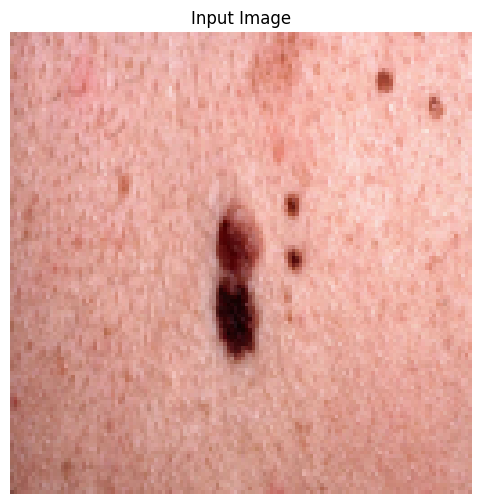

Loading model...
Error: [WinError 127] The specified procedure could not be found. Error loading "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\lib\c10_cuda.dll" or one of its dependencies.

Trying to create an image-only model...


Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_4044\4263256061.py", line 52, in <module>
    model = keras.models.load_model("best_model.keras")
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_api.py", line 189, in load_model
    return saving_lib.load_model(
           ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py", line 367, in load_model
    return _load_model_from_fileobj(
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py", line 444, in _load_model_from_fileobj
    model = _model_from_config(
            ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py", line 433, in _model_from_c

Error creating simplified model: [WinError 127] The specified procedure could not be found. Error loading "c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\lib\c10_cuda.dll" or one of its dependencies.


In [3]:
# Testing Keras Skin Cancer Model with Fixed Feature Dimensions

import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Use TensorFlow as backend

# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

print(f"Python version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Define configuration settings similar to training
class CFG:
    image_size = [128, 128]  # Input image size

# Function to preprocess the image
def preprocess_image(image_path, target_size=CFG.image_size):
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize
    image = cv2.resize(image, (target_size[1], target_size[0]), interpolation=cv2.INTER_AREA)
    
    # Normalize
    image = image.astype(np.float32) / 255.0
    
    return image

try:
    # Load and preprocess the image
    image_path = "D57_orig.jpg"
    image = preprocess_image(image_path)
    
    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()
    
    # Load the model
    print("Loading model...")
    model = keras.models.load_model("best_model.keras")
    print("Model loaded successfully!")
    
    # Get model input specifications
    print("\nModel input shapes:")
    for input_layer in model.inputs:
        print(f"- {input_layer.name}: {input_layer.shape}")
    
    # Prepare image input (batch dimension)
    image_batch = np.expand_dims(image, axis=0)
    
    # Create a feature tensor with the exact expected shape
    # From the error message, we know the model expects shape=(None, 71)
    feature_tensor = np.zeros((1, 71))
    
    print(f"\nCreating feature tensor with shape: {feature_tensor.shape}")
    
    # Make prediction
    print("Making prediction...")
    prediction = model.predict({
        "images": image_batch,
        "features": feature_tensor
    })
    
    # Display the result
    print(f"\nPrediction (probability of skin cancer): {prediction[0][0]:.4f}")
    
    # Visualize with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Cancer Probability: {prediction[0][0]:.4f}")
    plt.axis("off")
    plt.show()
    
    # Print interpretation guidance
    if prediction[0][0] > 0.5:
        print("IMPORTANT NOTE: The model predicts this lesion as SUSPICIOUS for skin cancer.")
        print("Higher values indicate higher confidence in the suspicious nature of the lesion.")
    else:
        print("IMPORTANT NOTE: The model predicts this lesion as LIKELY BENIGN.")
        print("Lower values indicate higher confidence in the benign nature of the lesion.")
    
    print("\nCAUTION: This prediction uses zero values for the tabular features, which may affect accuracy.")
    print("For more accurate results, you would need to use the same feature processing as during training.")
    
    print("\nDISCLAIMER: This is an experimental model and should NOT be used for actual medical diagnosis.")
    print("Always consult with a qualified dermatologist for proper diagnosis.")
    
except Exception as e:
    print(f"Error: {e}")
    
    # Additional debugging info
    import traceback
    traceback.print_exc()
    
    print("\nTrying to create an image-only model...")
    
    try:
        # Load model again
        model = keras.models.load_model("best_model.keras")
        
        # Inspect the model architecture to find layers
        print("\nModel layers:")
        for i, layer in enumerate(model.layers):
            print(f"{i}: {layer.name} - {layer.__class__.__name__}")
        
        # Find the concatenation layer
        concat_layer = None
        for layer in model.layers:
            if isinstance(layer, keras.layers.Concatenate):
                concat_layer = layer
                break
        
        if concat_layer:
            concat_layer_name = concat_layer.name
            print(f"\nFound concatenation layer: {concat_layer_name}")
            
            # Find the image branch up to the concatenation
            # This is a simplified approach - in a real scenario, we'd trace the graph more carefully
            input_layer = model.get_layer("images")
            
            # Extract appropriate layers from the model
            # This is a manual process since we can't automatically trace the execution graph
            
            print("\nWARNING: Creating a simplified model without the original weights")
            print("This is only for demonstration purposes and won't give accurate results")
            
            # Create a simplified model
            simplified_input = keras.Input(shape=(*CFG.image_size, 3))
            
            # Use EfficientNetV2 directly (requires keras_cv)
            import keras_cv
            backbone = keras_cv.models.EfficientNetV2Backbone.from_preset("efficientnetv2_b2_imagenet")
            x = backbone(simplified_input)
            x = keras.layers.GlobalAveragePooling2D()(x)
            x = keras.layers.Dropout(0.2)(x)
            x = keras.layers.Dense(128, activation="relu")(x)
            output = keras.layers.Dense(1, activation="sigmoid")(x)
            
            simplified_model = keras.Model(simplified_input, output)
            simplified_model.compile(
                optimizer="adam",
                loss="binary_crossentropy",
                metrics=["accuracy"]
            )
            
            print("\nCreated simplified model (note: this model is NOT trained)")
            
            # Make a prediction with the simplified model
            simple_pred = simplified_model.predict(image_batch)
            print(f"\nSimplified model prediction: {simple_pred[0][0]:.4f}")
            print("NOTE: This prediction is from an UNTRAINED model and is NOT reliable")
            
    except Exception as inner_e:
        print(f"Error creating simplified model: {inner_e}")